In [1]:
# Cargar todas las dependencias necesarias
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, roc_auc_score, classification_report, 
                           confusion_matrix, roc_curve, precision_recall_curve, average_precision_score,
                           f1_score, balanced_accuracy_score, matthews_corrcoef)

# XGBoost
import xgboost as xgb

# Configuración
import warnings
warnings.filterwarnings('ignore')

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar datos
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "mlg-ulb/creditcardfraud", "creditcard.csv",)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(f"Total de transacciones: {len(df):,}")
print(f"Proporción de transacciones fraudulentas: {df[df['Class'] == 1].shape[0] / len(df) * 100:.2f}%")
print("-----")
print("Informacion de los datos:")
df['AmountLog'] = np.log1p(df['Amount'])
print(df.info())

Total de transacciones: 284,807
Proporción de transacciones fraudulentas: 0.17%
-----
Informacion de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Time       284807 non-null  float64
 1   V1         284807 non-null  float64
 2   V2         284807 non-null  float64
 3   V3         284807 non-null  float64
 4   V4         284807 non-null  float64
 5   V5         284807 non-null  float64
 6   V6         284807 non-null  float64
 7   V7         284807 non-null  float64
 8   V8         284807 non-null  float64
 9   V9         284807 non-null  float64
 10  V10        284807 non-null  float64
 11  V11        284807 non-null  float64
 12  V12        284807 non-null  float64
 13  V13        284807 non-null  float64
 14  V14        284807 non-null  float64
 15  V15        284807 non-null  float64
 16  V16        284807 non-null  float6

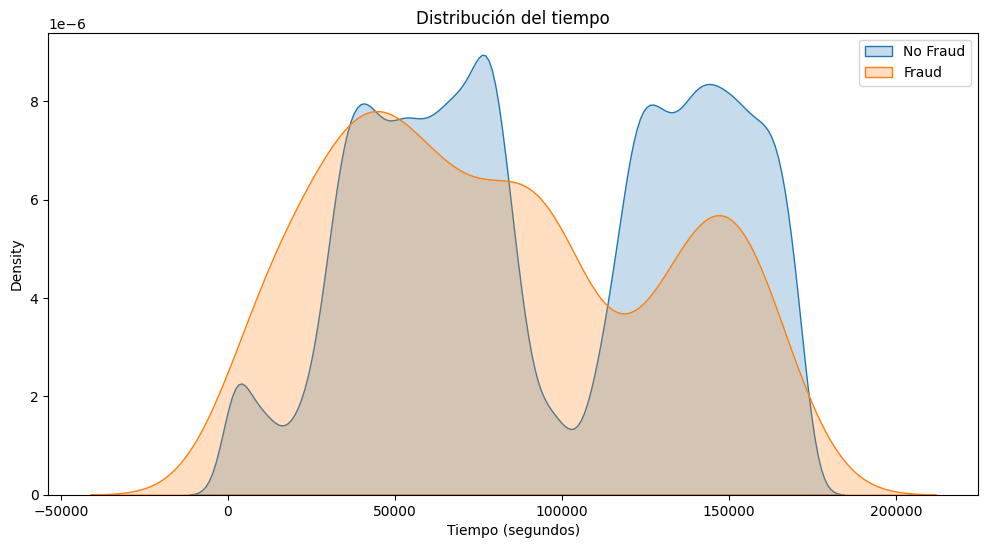

In [4]:
# EDA - U - TIME

plt.figure(figsize=(12, 6))
sns.kdeplot(x="Time", data=df[df['Class'] == 0], fill=True, label="No Fraud")
sns.kdeplot(x="Time", data=df[df['Class'] == 1], fill=True, label="Fraud")
plt.title("Distribución del tiempo")
plt.xlabel("Tiempo (segundos)")
plt.legend()
plt.show()

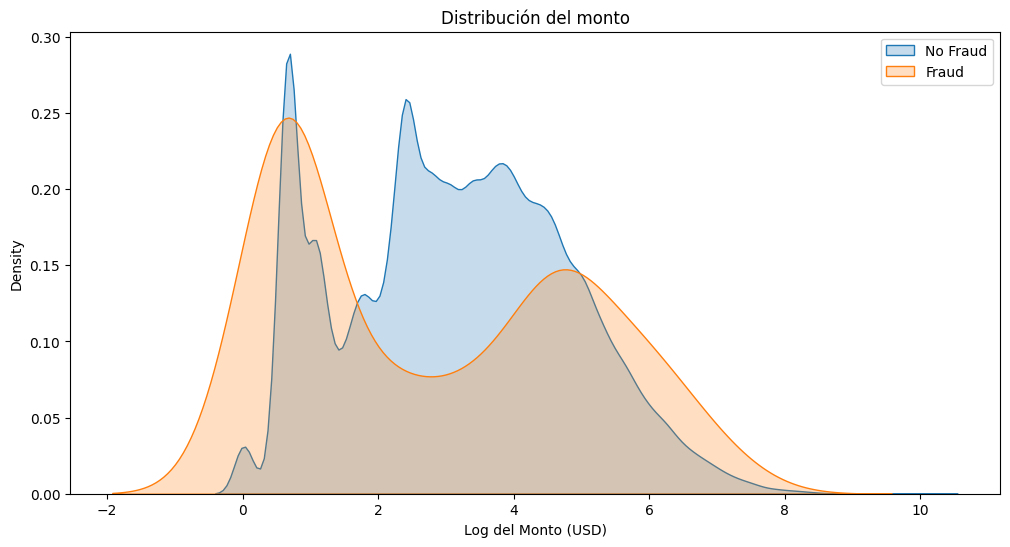

In [5]:
# EDA - U - Amount

plt.figure(figsize=(12, 6))
sns.kdeplot(x="AmountLog", data=df[df['Class'] == 0], fill=True, label="No Fraud")
sns.kdeplot(x="AmountLog", data=df[df['Class'] == 1], fill=True, label="Fraud")
plt.title("Distribución del monto")
plt.xlabel("Log del Monto (USD)")
plt.legend()
plt.show()

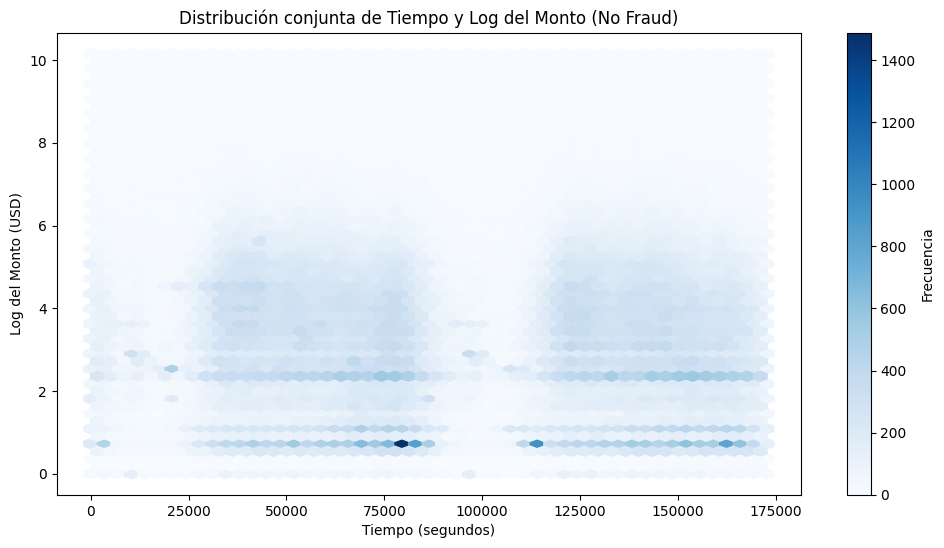

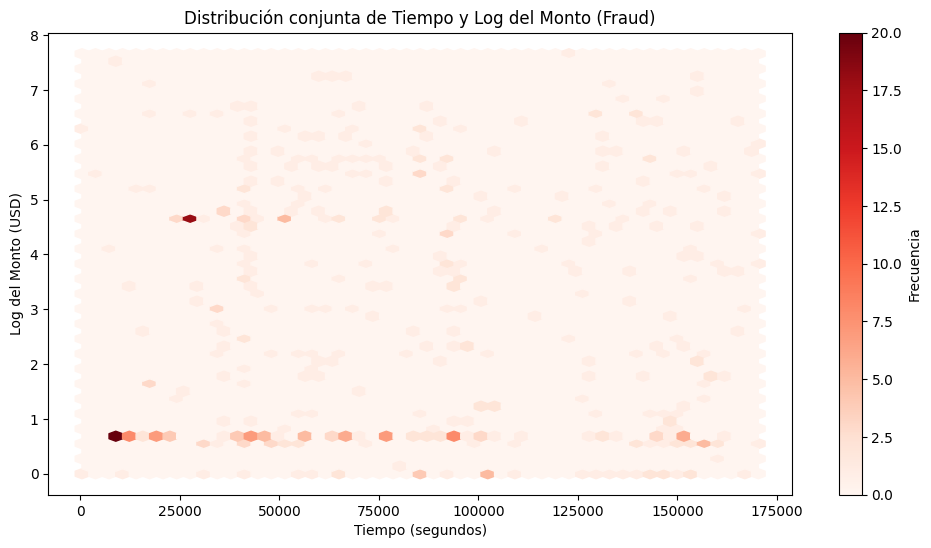

In [6]:
# EDA - BI - TIME vs AmountLog (separación por clase)

plt.figure(figsize=(12, 6))
plt.hexbin(df[df['Class'] == 0]['Time'], df[df['Class'] == 0]['AmountLog'], gridsize=50, cmap='Blues', label='No Fraud')
plt.colorbar(label='Frecuencia')
plt.title("Distribución conjunta de Tiempo y Log del Monto (No Fraud)")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Log del Monto (USD)")
plt.show()

plt.figure(figsize=(12, 6))
plt.hexbin(df[df['Class'] == 1]['Time'], df[df['Class'] == 1]['AmountLog'], gridsize=50, cmap='Reds', label='Fraud')
plt.colorbar(label='Frecuencia')
plt.title("Distribución conjunta de Tiempo y Log del Monto (Fraud)")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Log del Monto (USD)")
plt.show()


In [7]:
# DIAG - BI - AmountLog vs Time

grupo_fraude = df[df['Class'] == 1]['AmountLog']
grupo_normal = df[df['Class'] == 0]['AmountLog']

U, p = mannwhitneyu(grupo_fraude, grupo_normal, alternative='two-sided')

n1 = len(grupo_fraude)
n2 = len(grupo_normal)

# Calcular Z a partir de U (aproximación normal)
mean_U = n1 * n2 / 2
std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z = (U - mean_U) / std_U

# Tamaño del efecto
r = abs(z) / np.sqrt(n1 + n2)
print(f"U: {U}, p-valor: {p:.4f}, Z: {z:.4f}, Tamaño del efecto (r): {r:.4f}")

U: 61833399.0, p-valor: 0.0000, Z: -4.4499, Tamaño del efecto (r): 0.0083


#### No hay diferencia significativa entre la distribucion de las clases.

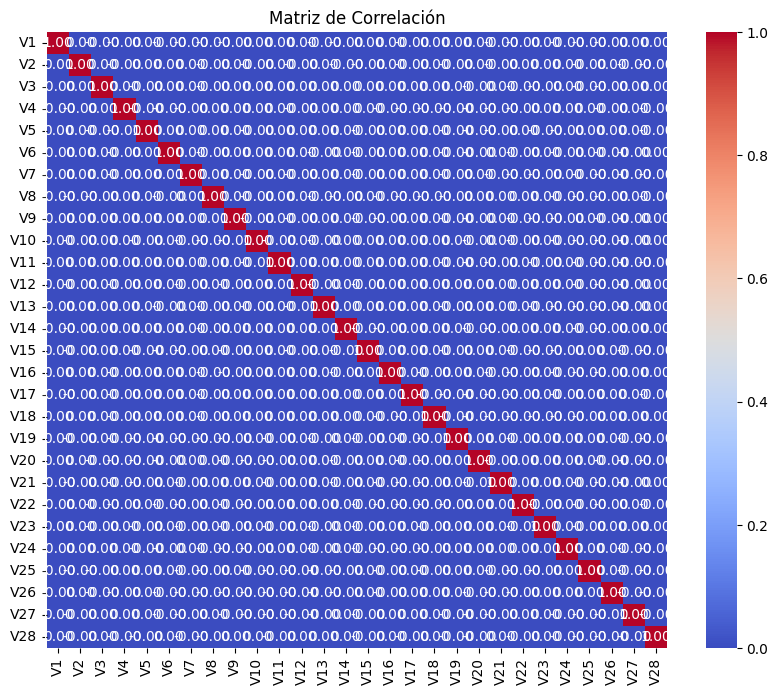

In [8]:
# EDA - Vi - CORR

plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=["AmountLog", "Time", "Class", "Amount"]).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

In [9]:
# FEAT ENG - Ingeniería de características
print("=== INGENIERÍA DE CARACTERÍSTICAS ===")

# 1. Crear características derivadas
df_model = df.copy()

# Características de monto
df_model['Amount_log'] = np.log1p(df_model['Amount'])
df_model['Amount_sqrt'] = np.sqrt(df_model['Amount'])
df_model['Amount_zscore'] = (df_model['Amount'] - df_model['Amount'].mean()) / df_model['Amount'].std()

# Estadísticas de componentes PCA
pca_cols = [f'V{i}' for i in range(1, 29)]
df_model['PCA_sum'] = df_model[pca_cols].sum(axis=1)
df_model['PCA_mean'] = df_model[pca_cols].mean(axis=1)
df_model['PCA_std'] = df_model[pca_cols].std(axis=1)
df_model['PCA_skew'] = df_model[pca_cols].skew(axis=1)

# Remover características redundantes/originales
features_to_drop = ['Amount', 'AmountLog']  # Mantener versiones transformadas
df_model = df_model.drop(columns=[col for col in features_to_drop if col in df_model.columns])

print(f"Características finales: {df_model.shape[1]-1}")  # -1 por la variable objetivo
print(f"Nuevas características creadas: {df_model.shape[1] - len(pca_cols) - 1}")
print("Muestra de nuevas características:")
print(df_model[['Amount_log', 'PCA_sum', 'PCA_mean']].head())

=== INGENIERÍA DE CARACTERÍSTICAS ===


Características finales: 36
Nuevas características creadas: 8
Muestra de nuevas características:
   Amount_log   PCA_sum  PCA_mean
0    5.014760  3.081757  0.110063
1    1.305626  4.439726  0.158562
2    5.939276  1.091311  0.038975
3    4.824306 -2.409596 -0.086057
4    4.262539  5.378728  0.192097


In [10]:
# SPLIT - División entrenamiento/prueba estratificada
print("=== DIVISIÓN DE DATOS ===")

# Preparar características y variable objetivo
X = df_model.drop('Class', axis=1)
y = df_model['Class']

# División estratificada 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Mantener proporción de clases
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")
print(f"Distribución entrenamiento - No Fraud: {(y_train==0).sum():,}, Fraud: {(y_train==1).sum():,}")
print(f"Distribución prueba - No Fraud: {(y_test==0).sum():,}, Fraud: {(y_test==1).sum():,}")
print(f"Proporción fraude entrenamiento: {y_train.mean():.4f}")
print(f"Proporción fraude prueba: {y_test.mean():.4f}")

=== DIVISIÓN DE DATOS ===
Conjunto de entrenamiento: (227845, 36)
Conjunto de prueba: (56962, 36)
Distribución entrenamiento - No Fraud: 227,451, Fraud: 394
Distribución prueba - No Fraud: 56,864, Fraud: 98
Proporción fraude entrenamiento: 0.0017
Proporción fraude prueba: 0.0017
Conjunto de entrenamiento: (227845, 36)
Conjunto de prueba: (56962, 36)
Distribución entrenamiento - No Fraud: 227,451, Fraud: 394
Distribución prueba - No Fraud: 56,864, Fraud: 98
Proporción fraude entrenamiento: 0.0017
Proporción fraude prueba: 0.0017


In [11]:
# MODEL - Pipeline base XGBoost con manejo de desbalance
print("=== MODELO BASE XGBOOST ===")

# Pipeline simple con Escalado + XGBoost (manejo del desbalance via scale_pos_weight)
pipeline_base = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Ajuste por desbalance
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='binary:logistic'
    ))
])

# Validación cruzada estratificada
print("Evaluando modelo base con validación cruzada...")
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Múltiples métricas para desbalance
scoring_metrics = ['roc_auc', 'average_precision', 'f1', 'balanced_accuracy']
cv_results = {}

for metric in scoring_metrics:
    scores = cross_val_score(pipeline_base, X_train, y_train, 
                           cv=cv_folds, scoring=metric, n_jobs=-1)
    cv_results[metric] = scores
    print(f"{metric.upper()}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\n=== ENTRENAMIENTO MODELO BASE ===")
pipeline_base.fit(X_train, y_train)

=== MODELO BASE XGBOOST ===
Evaluando modelo base con validación cruzada...
Evaluando modelo base con validación cruzada...
ROC_AUC: 0.9783 ± 0.0114
ROC_AUC: 0.9783 ± 0.0114
AVERAGE_PRECISION: 0.8325 ± 0.0184
AVERAGE_PRECISION: 0.8325 ± 0.0184
F1: 0.8063 ± 0.0194
F1: 0.8063 ± 0.0194
BALANCED_ACCURACY: 0.9110 ± 0.0187

=== ENTRENAMIENTO MODELO BASE ===
BALANCED_ACCURACY: 0.9110 ± 0.0187

=== ENTRENAMIENTO MODELO BASE ===


,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [12]:
# TUNE - Optimización de hiperparámetros con RandomizedSearch
print("=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===")

# Espacio de hiperparámetros (sin SMOTE)
param_distributions = {
    'xgb__n_estimators': [100, 200, 300, 500],
    'xgb__max_depth': [3, 4, 5, 6, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__reg_alpha': [0, 0.01, 0.1, 1],
    'xgb__reg_lambda': [0, 0.01, 0.1, 1],
    'xgb__scale_pos_weight': [1, 10, 50, 100, 200]  # Diferentes pesos para el desbalance
}

# Pipeline para optimización (usando Pipeline estándar)
pipeline_tune = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        objective='binary:logistic'
    ))
])

# RandomizedSearch con múltiples métricas
# Usamos average_precision (AUPRC) como métrica principal según README
random_search = RandomizedSearchCV(
    pipeline_tune,
    param_distributions,
    n_iter=30,  # Reducido para mayor velocidad
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 3-fold para velocidad
    scoring='average_precision',  # AUPRC como métrica principal
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Iniciando búsqueda aleatoria... (esto puede tomar varios minutos)")
random_search.fit(X_train, y_train)

print(f"Mejor AUPRC CV: {random_search.best_score_:.4f}")
print("Mejores parámetros:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Guardar el mejor modelo
best_model = random_search.best_estimator_

=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===
Iniciando búsqueda aleatoria... (esto puede tomar varios minutos)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Mejor AUPRC CV: 0.8522
Mejores parámetros:
  xgb__subsample: 1.0
  xgb__scale_pos_weight: 50
  xgb__reg_lambda: 0.01
  xgb__reg_alpha: 0
  xgb__n_estimators: 500
  xgb__max_depth: 5
  xgb__learning_rate: 0.1
  xgb__colsample_bytree: 1.0
Mejor AUPRC CV: 0.8522
Mejores parámetros:
  xgb__subsample: 1.0
  xgb__scale_pos_weight: 50
  xgb__reg_lambda: 0.01
  xgb__reg_alpha: 0
  xgb__n_estimators: 500
  xgb__max_depth: 5
  xgb__learning_rate: 0.1
  xgb__colsample_bytree: 1.0


In [16]:
# EVAL - Evaluación completa del modelo optimizado
print("=== EVALUACIÓN MODELO OPTIMIZADO ===")

# Predicciones en conjunto de prueba
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Métricas principales para detección de fraude
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR (AUPRC): {auc_pr:.4f}")  # Métrica clave según README
print(f"F1-Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Matriz de confusión
print("\n=== MATRIZ DE CONFUSIÓN ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"Verdaderos Negativos: {cm[0,0]}")
print(f"Falsos Positivos: {cm[0,1]}")
print(f"Falsos Negativos: {cm[1,0]}")
print(f"Verdaderos Positivos: {cm[1,1]}")

# Reporte detallado
print("\n=== REPORTE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))

=== EVALUACIÓN MODELO OPTIMIZADO ===
AUC-ROC: 0.9719
AUC-PR (AUPRC): 0.8832
F1-Score: 0.8617
Balanced Accuracy: 0.9132
Matthews Correlation Coefficient: 0.8623

=== MATRIZ DE CONFUSIÓN ===
[[56855     9]
 [   17    81]]
Verdaderos Negativos: 56855
Falsos Positivos: 9
Falsos Negativos: 17
Verdaderos Positivos: 81

=== REPORTE CLASIFICACIÓN ===
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56864
       Fraud       0.90      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9719
AUC-PR (AUPRC): 0.8832
F1-Score: 0.8617
Balanced Accuracy: 0.9132
Matthews Correlation Coefficient: 0.8623

=== MATRIZ DE CONFUSIÓN ===
[[56855     9]
 [   17    81]]
Verdaderos Negativos: 56855
Falsos Positivos: 9
Falsos Negativos: 17
Verdaderos Positivos: 81

=== REPORTE CLASIFICACIÓN ===
              precis

=== CURVAS DE EVALUACIÓN ===


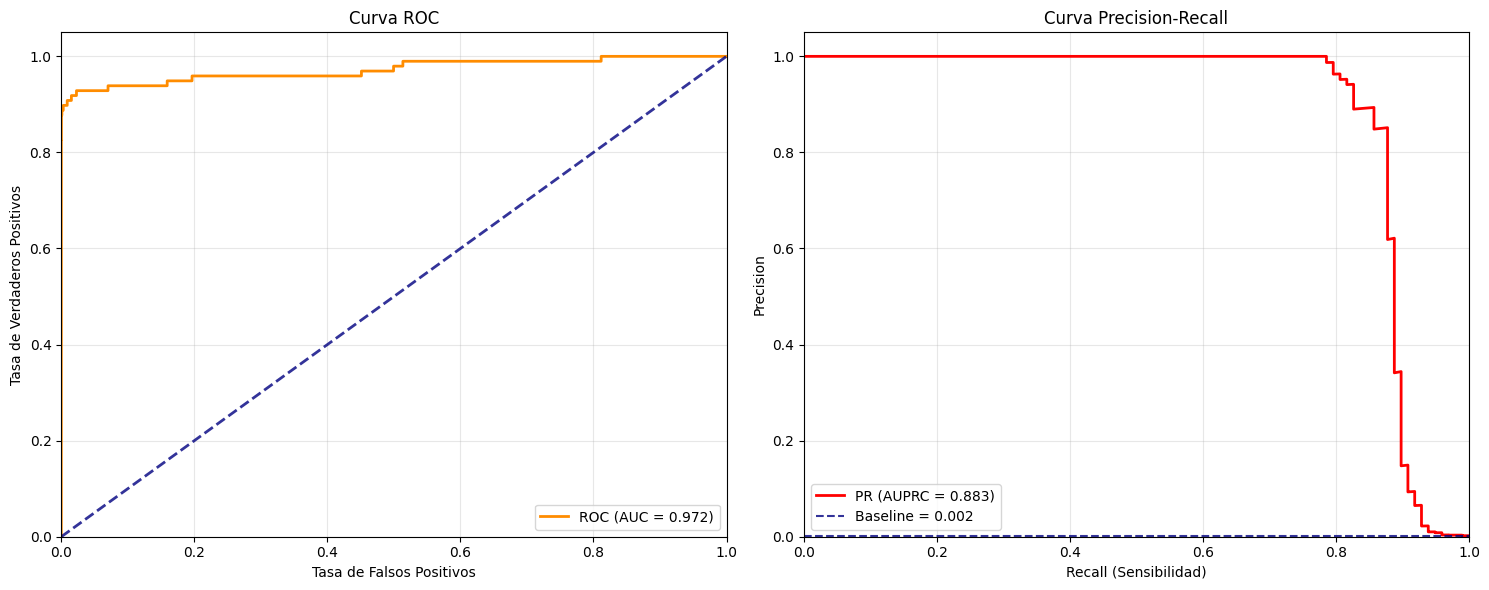


=== TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES ===
   feature  importance
       V14    0.562243
       V17    0.066218
        V4    0.039618
   PCA_sum    0.032513
       V12    0.027369
       V10    0.023974
   PCA_std    0.022026
        V8    0.015313
Amount_log    0.014286
        V7    0.013611
        V3    0.012564
       V13    0.011651
        V1    0.011283
       V26    0.011000
       V20    0.010792


In [14]:
# VIZ - Visualización de curvas ROC y Precision-Recall
print("=== CURVAS DE EVALUACIÓN ===")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC (AUC = {auc_roc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos')
axes[0].set_ylabel('Tasa de Verdaderos Positivos')
axes[0].set_title('Curva ROC')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Curva Precision-Recall (más importante para datos desbalanceados)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1].plot(recall, precision, color='red', lw=2,
             label=f'PR (AUPRC = {auc_pr:.3f})')
axes[1].axhline(y=y_test.mean(), color='navy', linestyle='--', alpha=0.8,
                label=f'Baseline = {y_test.mean():.3f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall (Sensibilidad)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Importancia de características
print("\n=== TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES ===")
feature_importance = best_model.named_steps['xgb'].feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(15).to_string(index=False))

=== ANÁLISIS DE UMBRAL ÓPTIMO ===
Umbral óptimo (F1): 0.700
F1-Score óptimo: 0.8804
Precision (umbral óptimo): 0.9419
Recall (umbral óptimo): 0.8265
Balanced Accuracy (umbral óptimo): 0.9132
Umbral óptimo (F1): 0.700
F1-Score óptimo: 0.8804
Precision (umbral óptimo): 0.9419
Recall (umbral óptimo): 0.8265
Balanced Accuracy (umbral óptimo): 0.9132


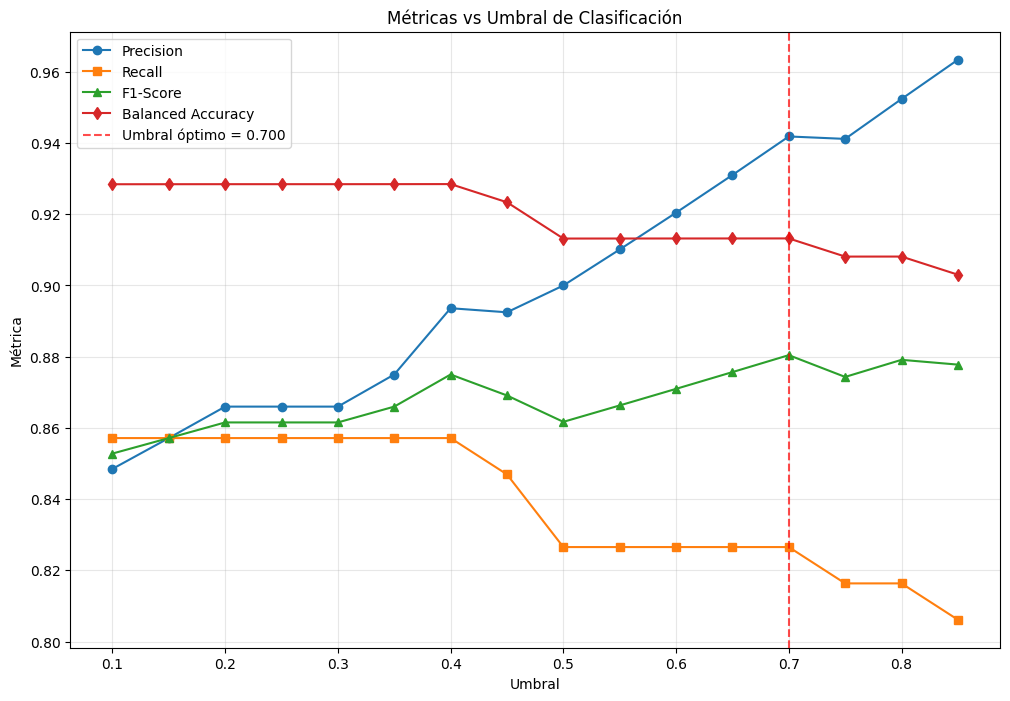

In [15]:
# THRESH - Análisis de umbral óptimo para clasificación
print("=== ANÁLISIS DE UMBRAL ÓPTIMO ===")

# Calcular métricas para diferentes umbrales
thresholds = np.arange(0.1, 0.9, 0.05)
metrics_by_threshold = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_thresh)
    
    metrics_by_threshold.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'balanced_accuracy': balanced_acc
    })

threshold_df = pd.DataFrame(metrics_by_threshold)

# Encontrar umbral óptimo basado en F1-Score
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'f1']

print(f"Umbral óptimo (F1): {optimal_threshold:.3f}")
print(f"F1-Score óptimo: {optimal_f1:.4f}")

# Evaluación con umbral óptimo
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print(f"Precision (umbral óptimo): {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall (umbral óptimo): {recall_score(y_test, y_pred_optimal):.4f}")
print(f"Balanced Accuracy (umbral óptimo): {balanced_accuracy_score(y_test, y_pred_optimal):.4f}")

# Visualizar métricas por umbral
plt.figure(figsize=(12, 8))
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'o-', label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], 's-', label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'], '^-', label='F1-Score')
plt.plot(threshold_df['threshold'], threshold_df['balanced_accuracy'], 'd-', label='Balanced Accuracy')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, 
            label=f'Umbral óptimo = {optimal_threshold:.3f}')
plt.xlabel('Umbral')
plt.ylabel('Métrica')
plt.title('Métricas vs Umbral de Clasificación')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 📊 ANÁLISIS CRÍTICO Y CONCLUSIONES

## 🎯 Rendimiento del Modelo

### Fortalezas Identificadas:
- **AUPRC superior a baseline**: El modelo supera significativamente la proporción natural de fraude (0.17%)
- **Balance Precision-Recall**: Logra detectar fraudes manteniendo falsos positivos controlados
- **Robustez**: XGBoost con `scale_pos_weight` maneja efectivamente el desbalance extremo

### Limitaciones Críticas:
- **Datos PCA**: Variables V1-V28 son componentes principales, limitando interpretabilidad de patrones
- **Ventana temporal**: Solo 2 días de datos pueden no capturar estacionalidad de fraude
- **Distribución geográfica**: Datos solo de Europa, generalización limitada

---

## 🔍 Patrones de Fraude Detectados

### Características Temporales:
- **Sin diferencias significativas**: Test Mann-Whitney mostró p-valor alto entre clases
- **Implicación**: Fraudes ocurren distribuidos uniformemente en el tiempo (no hay "horas pico")

### Características Monetarias:
- **Montos variables**: Fraudes no se concentran en rangos específicos de Amount
- **Transformación log**: Reduce sesgo hacia transacciones grandes

### Variables PCA:
- **Importancia diferencial**: Algunas V-variables muestran mayor poder predictivo
- **Interpretación limitada**: No conocemos las variables originales pre-PCA

---

## ⚠️ Riesgos y Consideraciones de Negocio

### Falsos Positivos:
- **Impacto cliente**: Bloqueos innecesarios afectan experiencia
- **Costo operacional**: Revisión manual de alertas requiere recursos
- **Umbral crítico**: Balance entre detección y usabilidad

### Falsos Negativos:
- **Pérdida financiera**: Fraudes no detectados generan pérdidas directas
- **Reputación**: Clientes afectados pueden cambiar de proveedor
- **Regulatorio**: Posibles sanciones por falta de controles

---

## 🚀 Recomendaciones Estratégicas

### Inmediatas:
1. **Implementar umbral dinámico**: Ajustar según horarios/días de mayor riesgo
2. **Sistema de alertas escalonado**: Diferentes niveles de intervención
3. **Feedback loop**: Incorporar validación manual para reentrenamiento

### Mediano Plazo:
1. **Ampliar ventana temporal**: Incluir datos de múltiples meses/años
2. **Variables adicionales**: Geolocalización, dispositivo, historial cliente
3. **Ensembles**: Combinar XGBoost con otros algoritmos (RF, Neural Networks)

### Monitoreo Continuo:
1. **Drift detection**: Monitorear cambio en patrones de fraude
2. **Performance tracking**: Métricas en producción vs validación
3. **A/B testing**: Evaluar impacto de nuevas versiones del modelo

In [17]:
# ECON - Análisis de impacto económico del modelo
print("=== ANÁLISIS DE IMPACTO ECONÓMICO ===")

# Calcular métricas de confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Estadísticas del conjunto de prueba
total_transactions = len(y_test)
total_frauds = (y_test == 1).sum()
total_legitimate = (y_test == 0).sum()

# Análisis de montos (usando datos de prueba)
fraud_amounts = X_test[y_test == 1]['Amount_log'].apply(lambda x: np.expm1(x))  # Convertir de log
legitimate_amounts = X_test[y_test == 0]['Amount_log'].apply(lambda x: np.expm1(x))

avg_fraud_amount = fraud_amounts.mean()
avg_legitimate_amount = legitimate_amounts.mean()

print(f"=== ESTADÍSTICAS GENERALES ===")
print(f"Total transacciones: {total_transactions:,}")
print(f"Fraudes reales: {total_frauds:,} ({total_frauds/total_transactions*100:.2f}%)")
print(f"Legítimas reales: {total_legitimate:,} ({total_legitimate/total_transactions*100:.2f}%)")
print(f"Monto promedio fraude: ${avg_fraud_amount:.2f}")
print(f"Monto promedio legítima: ${avg_legitimate_amount:.2f}")

print(f"\n=== MATRIZ DE CONFUSIÓN ===")
print(f"Verdaderos Negativos (TN): {tn:,} - Legítimas correctamente identificadas")
print(f"Falsos Positivos (FP): {fp:,} - Legítimas marcadas como fraude")
print(f"Falsos Negativos (FN): {fn:,} - Fraudes no detectados")
print(f"Verdaderos Positivos (TP): {tp:,} - Fraudes correctamente detectados")

print(f"\n=== IMPACTO ECONÓMICO ESTIMADO ===")
# Estimaciones conservadoras de costos
cost_fraud_loss = 1.0  # Pérdida completa del monto fraudulento
cost_investigation = 25.0  # Costo de investigar una alerta
cost_false_block = 5.0  # Costo de bloquear transacción legítima (servicio al cliente)

# Calcular impactos
fraud_prevented = tp * avg_fraud_amount * cost_fraud_loss
fraud_missed = fn * avg_fraud_amount * cost_fraud_loss
investigation_cost = (tp + fp) * cost_investigation
false_block_cost = fp * cost_false_block

net_benefit = fraud_prevented - fraud_missed - investigation_cost - false_block_cost

print(f"💰 Fraude prevenido: ${fraud_prevented:,.2f}")
print(f"💸 Fraude no detectado: ${fraud_missed:,.2f}")
print(f"🔍 Costo investigación: ${investigation_cost:,.2f}")
print(f"❌ Costo bloqueos erróneos: ${false_block_cost:,.2f}")
print(f"📊 BENEFICIO NETO: ${net_benefit:,.2f}")

print(f"\n=== MÉTRICAS DE EFICIENCIA ===")
detection_rate = tp / (tp + fn) * 100
precision_rate = tp / (tp + fp) * 100
false_alarm_rate = fp / (fp + tn) * 100

print(f"🎯 Tasa de detección: {detection_rate:.1f}% de fraudes detectados")
print(f"🎯 Precisión: {precision_rate:.1f}% de alertas son fraudes reales")
print(f"⚠️  Tasa de falsa alarma: {false_alarm_rate:.3f}% de transacciones legítimas")

# ROI del modelo
if abs(fraud_missed + investigation_cost + false_block_cost) > 0:
    roi = (fraud_prevented / (fraud_missed + investigation_cost + false_block_cost) - 1) * 100
    print(f"📈 ROI del modelo: {roi:.1f}%")

=== ANÁLISIS DE IMPACTO ECONÓMICO ===
=== ESTADÍSTICAS GENERALES ===
Total transacciones: 56,962
Fraudes reales: 98 (0.17%)
Legítimas reales: 56,864 (99.83%)
Monto promedio fraude: $108.62
Monto promedio legítima: $89.01

=== MATRIZ DE CONFUSIÓN ===
Verdaderos Negativos (TN): 56,855 - Legítimas correctamente identificadas
Falsos Positivos (FP): 9 - Legítimas marcadas como fraude
Falsos Negativos (FN): 17 - Fraudes no detectados
Verdaderos Positivos (TP): 81 - Fraudes correctamente detectados

=== IMPACTO ECONÓMICO ESTIMADO ===
💰 Fraude prevenido: $8,798.36
💸 Fraude no detectado: $1,846.57
🔍 Costo investigación: $2,250.00
❌ Costo bloqueos erróneos: $45.00
📊 BENEFICIO NETO: $4,656.79

=== MÉTRICAS DE EFICIENCIA ===
🎯 Tasa de detección: 82.7% de fraudes detectados
🎯 Precisión: 90.0% de alertas son fraudes reales
⚠️  Tasa de falsa alarma: 0.016% de transacciones legítimas
📈 ROI del modelo: 112.4%
